<a href="https://githubtocolab.com/alsinmr/ConferenceExamples/blob/master/GNMR2023/exchange1D.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>

# Exchange in simple, 1D spectra

In [ ]:
!git clone https://github.com/alsinmr/ConferenceExamples.git
%cd /content/ConferenceExamples/GNMR2023
import setup

In [ ]:
#Sometimes, there is a delay between setup finishing and being able to complete the module loads
from importlib.machinery import SourceFileLoader
RS = SourceFileLoader("pyRelaxSim", "/content/pyRelaxSim/__init__.py").load_module()
import numpy as np
import matplotlib.pyplot as plt

In [1]:
# # This cell is only for testing on my computer
# import sys
# sys.path.append('/Users/albertsmith/Documents/GitHub')
# sys.path.append('/Users/albertsmith/Documents/GitHub.nosync')
# import SLEEPY as RS
# import numpy as np
# import matplotlib.pyplot as plt
# RS.Defaults['parallel']=False
# %matplotlib notebook

## Build the system
The first step is to build the system, which will have a single nucleus, with two different chemical shifts.

In [2]:
ex0=RS.ExpSys(Nucs='13C',v0H=600)    #We need a description of the experiment for both states (ex0, ex1)
ex1=ex0.copy()
ex0.set_inter(Type='CS',i=0,ppm=-5)   #Add the chemical shifts
ex1.set_inter(Type='CS',i=0,ppm=5)

## Add the exchange process (symmetric exchange)
First, export this sytem into Liouville space, allowing us to introduce an exchange process. Then we'll define a correlation time and population 1 and population 2. Here we start assuming the populations, $p_1$ and $p_2$ are equal

In [3]:
L=RS.Liouvillian((ex0,ex1))           #Builds the two different Hamiltonians and exports them to Liouville space

tc=1e-3     #Correlation time (10 s)
p1=0.5  #Population of state 1
p2=1-p1  #Population of state 2

kex=1/(2*tc)*(np.array([[-1,1],[1,-1]])+(p1-p2)*np.array([[1,1],[-1,-1]]))
L.kex=kex

## Run as a 1D Experiment
We'll start the magnetization on $S_x$ and observe $S^+$. We need a propagator from the Liouville matrix.

In [4]:
rho=RS.Rho(rho0='S0x',detect='S0p')
Dt=1/(2*10*150)  #For a 10 ppm shift difference, this should be enough to easily capture both peaks in the spectrum 
Uevol=L.U(Dt=Dt)  #Propagator for the evolution time

_=rho.DetProp(Uevol,n=512)

## Plot the results

<AxesSubplot:xlabel='$t$ / ms', ylabel='<$S_0^+$>'>

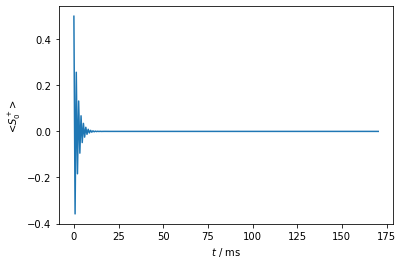

In [5]:
rho.plot(FT=False,imag=False)

## Sweep through a range of correlation times to observe coalescence

In [6]:
tc0=np.logspace(-5,-2,13)[:-1]
S=list()
for tc in tc0:
    L.kex=[[-1/(2*tc),1/(2*tc)],[1/(2*tc),-1/(2*tc)]]
    Uevol=L.U(Dt=Dt)
    rho.clear()
    rho.DetProp(Uevol,n=512)
    S.append(rho.FT[0].real)

Plot the results

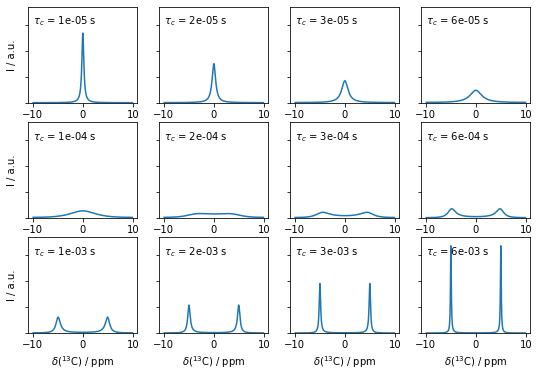

In [9]:
fig,ax=plt.subplots(3,4)
fig.set_size_inches([9,6])
ax=ax.reshape(ax.size)
sm=0
for S0,a in zip(S,ax):
    a.plot(rho.v_axis/ex0.v0[0]*1e6,S0)
    if a.is_last_row():
        a.set_xlabel(r'$\delta (^{13}$C) / ppm')
    if a.is_first_col():
        a.set_ylabel('I / a.u.')
    a.set_yticklabels('')
    sm=max(sm,S0.max())
for a,tc in zip(ax,tc0):
    a.set_ylim([0,sm*1.1])
    a.text(-10,sm*.9,r'$\tau_c$'+f' = {tc:.0e} s')
    

## Now we repeat, but use asymmetric exchange to see if coalescence occurs

In [10]:
p1=0.75
p2=1-p1

tc0=np.logspace(-6,-2,13)[:-1]
S=list()
for tc in tc0:
    L.kex=1/(2*tc)*(np.array([[-1,1],[1,-1]])+(p1-p2)*np.array([[1,1],[-1,-1]]))
    Uevol=L.U(Dt=Dt)
    rho.clear()
    rho.DetProp(Uevol,n=512)
    S.append(rho.FT[0].real)

Plot the results

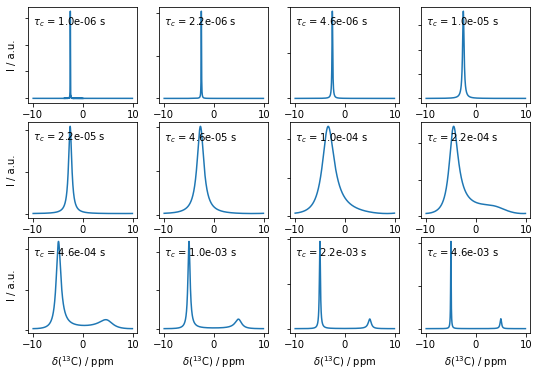

In [12]:
fig,ax=plt.subplots(3,4)
fig.set_size_inches([9,6])
ax=ax.reshape(ax.size)
sm=0
for S0,a in zip(S,ax):
    a.plot(rho.v_axis/ex0.v0[0]*1e6,S0)
    if a.is_last_row():
        a.set_xlabel(r'$\delta (^{13}$C) / ppm')
    if a.is_first_col():
        a.set_ylabel('I / a.u.')
    a.set_yticklabels('')
    sm=max(sm,S0.max())
for a,tc in zip(ax,tc0):
    a.text(-10,a.get_ylim()[1]*.8,r'$\tau_c$'+f' = {tc:.1e} s')